In [1]:
import sys
import numpy as npy
from scipy import interpolate
import math
import scipy.misc as sm
import matplotlib.pyplot as plt
# make graphics inline
%matplotlib inline
from ptycho_trans import *

Define the input parameters (scan_num,sign,n_iterations,mode_flag,multislice_flag):

In [2]:
# save_dir+...+'_'+self.scan_num+'_'+self.sign
scan_num = 1 #scan number:  
sign = 'hxn' #saving file name

n_iterations = 100

mode_flag = False
multislice_flag = False

Define the general parameters of the HXN application

In [3]:
energy     = 8000*1.60217657e-19 # 8 keV in J
pixel_size      =  55 * 1e-6 # 55 um pixels
real_pixel_size =  5.5 * 1e-9 # real space pixel size in m

Load the probe file:

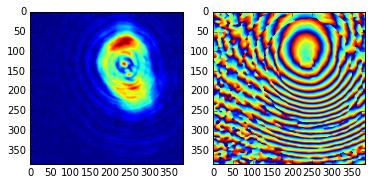

In [4]:
probeFile  = './hxn/probe.npy'
probe = npy.load(probeFile) # (384, 384)

plt.subplot(1,2,1)
plt.imshow(abs(probe))
plt.subplot(1,2,2)
plt.imshow(np.angle(probe))

In [5]:
# Detector side in pixels
nx_prb = probe.shape[0] 
ny_prb = probe.shape[1] 
det_side = nx_prb
print det_side

384


Load a file with a sequence of the scan x-y points and shift them into the positive plane: 

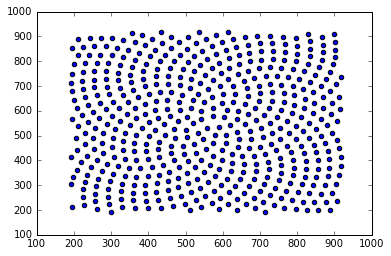

In [6]:
scanFile   = './hxn/scan.npy'
points  = np.load(scanFile)

X = points[0] # [-363, 362]
Y = points[1] # [-363, 363]

X -= min(X)
Y -= min(Y) 

X += det_side/2
Y += det_side/2

plt.scatter(X, Y)
plt.show()

points[0] = X
points[1] = Y

In [7]:
print min(X), max(X), min(Y), max(Y)

192.0 917.0 192.0 918.0


Load the object file:

In [8]:
objectFile = './hxn/object.npy'
object = npy.load(objectFile) # (1170, 1172)

nx_obj = max(X) - min(X) + probe.shape[0] + 10
ny_obj = max(Y) - min(Y) + probe.shape[1] + 10

nx_obj = nx_obj + np.mod(nx_obj, 2)
ny_obj = ny_obj + np.mod(ny_obj, 2)

print nx_obj, ny_obj, object.shape[0], object.shape[1]

1120.0 1120.0 1170 1172


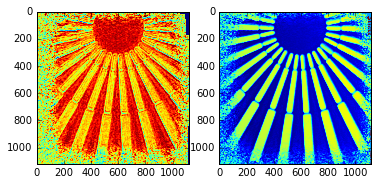

In [9]:
object = object[0: int(nx_obj), object.shape[1] - int(ny_obj): object.shape[1]]

plt.subplot(1,2,1)
plt.imshow(abs(object))
plt.subplot(1,2,2)
plt.imshow(np.angle(object))

In [10]:
object.shape

(1120, 1120)

Load frames

In [11]:
tmp = npy.load('/home/malitsky/apps/hxn/8ab5c379a0d8/data/diff_data_2304dbeb-1ad3-46ba-8e72-8ab5c379a0d8.npy')

nframes = X.size

nz, nx,ny = npy.shape(tmp)
print nx, ny, nz

384 384 512


85900.587181


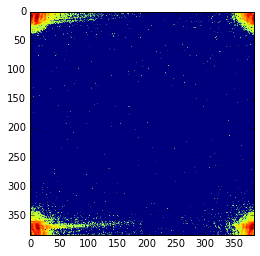

In [12]:
plt.imshow(np.log10(tmp[0, :,:]+0.1));print np.sum(tmp[0,:,:])

Create data list and initialize ptycho_trans

In [13]:
diffamp = [npy.copy(tmp[i, :,:]) for i in range(nz)]
del(tmp)

85900.587181


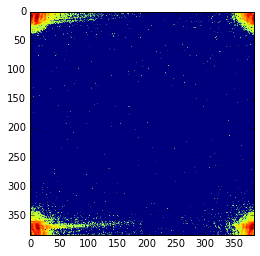

In [15]:
plt.imshow(np.log10(diffamp[0]+0.1));print np.sum(diffamp[0])

In [16]:
recon = ptycho_trans(diffamp)

Using pyfftw


Beamline parameters

In [17]:
recon.x_roi = nx              #data array size in x
recon.y_roi = ny              #data array size in y

recon.ccd_pixel_um =  pixel_size     #detector pixel size, 55 (um)

wavelength = 1.98644e-25/energy # 1.5497979726416796e-10
recon.lambda_nm = wavelength*1.e+9  # x-ray wavelength, 0.1 (nm) -> 0.155

distance   = (det_side * pixel_size * real_pixel_size)/ wavelength # 0.749517047064
recon.z_m =  distance  # detector-to-sample distance, 1 (m) -> 0.749517047064

Scan parameters

In [18]:
# round, mesh and fermat
recon.cal_scan_pattern_flag = False
recon.points = points
recon.num_points = nz

Probe parameters

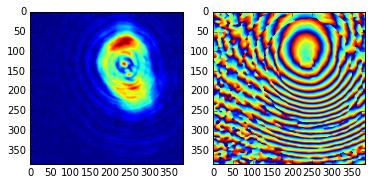

In [19]:
recon.init_prb_flag = False  #True to start with a random guess. False to load a pre-existing array

recon.prb = probe
# recon.prb = npy.load('./prb_init.npy')

recon.nx_prb = nx
recon.ny_prb = ny

recon.start_update_probe = 2    # iteration number for probe updating

plt.subplot(1,2,1)
plt.imshow(abs(recon.prb))
plt.subplot(1,2,2)
plt.imshow(np.angle(recon.prb))

Object parameters

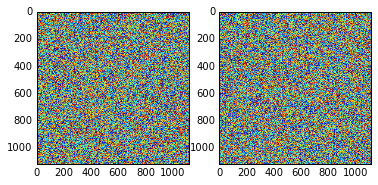

In [20]:
recon.init_obj_flag = False                #True to start with a random guess. False to load a pre-existing array

recon.obj = object
recon.obj = npy.load('./obj_init.npy')

recon.solution = object

# update object
recon.start_update_object = 0

recon.amp_max = 1.  #up limit of allowed object amplitude range
recon.amp_min = 0.       #low limit of allowed object amplitude range
recon.pha_max = npy.pi/2.       #up limit of allowed object phase range
recon.pha_min = -npy.pi/2.         #low limit of allowed object phase range

recon.alpha = 1.e-8

plt.subplot(1,2,1)
plt.imshow(abs(recon.obj))
plt.subplot(1,2,2)
plt.imshow(np.angle(recon.obj))

Algorithm parameters

In [21]:
recon.n_iterations = n_iterations   #number of iterations

recon.start_ave = 0.8

recon.sf_flag = False # use numpy fft

recon.dm_version = 1 # difference map : run_parallel_over_points
recon.processes = 1
recon.beta = 0.9 #reconstruction feedback parameters

recon.position_correction_flag = False
recon.position_correction_start = 50
recon.position_correction_step = 10

Output parameters

In [22]:
recon.scan_num = scan_num  # scan number
recon.sign = sign          # saving file name

Advanced parameters

In [23]:
recon.mode_flag = mode_flag
recon.save_tmp_pic_flag = False
recon.prb_mode_num = 10
recon.obj_mode_num = 1

recon.multislice_flag = multislice_flag
if recon.multislice_flag:
    recon.slice_num = 3
    recon.slice_spacing_m = 50.e-6

#parameters for partial coherence calculation
recon.pc_flag = False
recon.update_coh_flag = False
recon.kernal_n = 16           # kernal size
recon.pc_sigma = 0.2          # initial guess of kernal sigma

In [24]:
# recon.recon_code = __file__        #Copy the code
recon.recon_ptycho()

0.00275 0.00275
1119.0 1120.0
0 object_chi= 0.774607604913 probe_chi= 0.0 diff_chi= 0.690553562154


ptycho_trans.py:1369: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None in results:


1 object_chi= 0.997256989896 probe_chi= 0.0 diff_chi= 0.732302919591
2 object_chi= 0.89823373018 probe_chi= 0.216151334665 diff_chi= 0.708167838715
3 object_chi= 0.930972083725 probe_chi= 0.153921925398 diff_chi= 0.702706730055
4 object_chi= 0.823721068424 probe_chi= 0.10298696417 diff_chi= 0.642191149683
5 object_chi= 0.730054234153 probe_chi= 0.0834799552733 diff_chi= 0.594638197024
6 object_chi= 0.667440959794 probe_chi= 0.0643104576568 diff_chi= 0.553302658288
7 object_chi= 0.627133558886 probe_chi= 0.0659947041941 diff_chi= 0.526213288259
8 object_chi= 0.618798720911 probe_chi= 0.0672689347598 diff_chi= 0.512777791347
9 object_chi= 0.632172914819 probe_chi= 0.0723752710908 diff_chi= 0.508277271226
10 object_chi= 0.64362088384 probe_chi= 0.0739616679621 diff_chi= 0.512298192998
11 object_chi= 0.652425853333 probe_chi= 0.0744045674898 diff_chi= 0.520975143429
12 object_chi= 0.662015611372 probe_chi= 0.0725637343798 diff_chi= 0.530999296702
13 object_chi= 0.663128314602 probe_chi= 0.

In [25]:
# recon.save_recon()

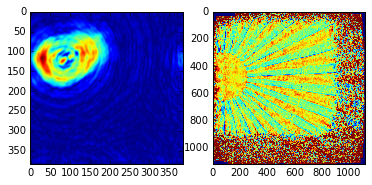

In [26]:
# recon.display_recon()
plt.subplot(121)
plt.imshow(np.flipud(np.abs(recon.prb.T)))
plt.subplot(122)
plt.imshow(np.flipud(np.abs(recon.obj.T)))

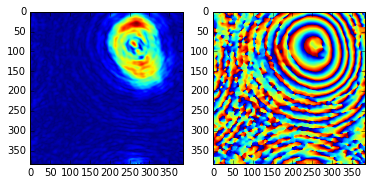

In [27]:
plt.subplot(121)
plt.imshow(np.abs(recon.prb))
plt.subplot(122)
plt.imshow(np.angle(recon.prb))

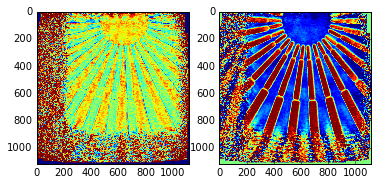

In [28]:
plt.subplot(121)
plt.imshow(np.abs(recon.obj))
plt.subplot(122)
plt.imshow(np.angle(recon.obj))